Confusion Matrix:
[[2 2 0]
 [2 1 0]
 [0 0 3]]


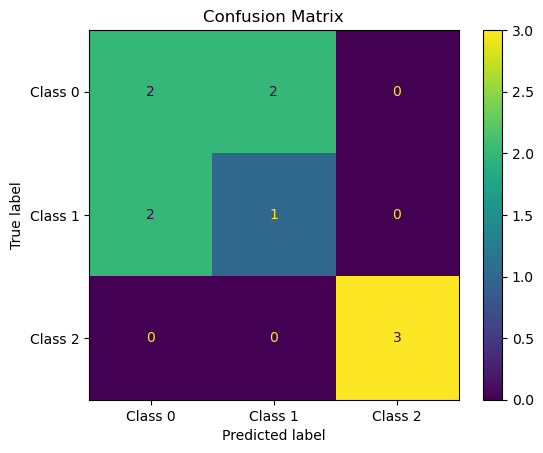

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have your true labels (y_true) and predicted labels (y_pred)
y_true = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0]
y_pred = [0, 0, 2, 1, 1, 2, 1, 0, 2, 0]

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Create the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Confusion Matrix:
[[2 2 0]
 [2 1 0]
 [0 0 3]]


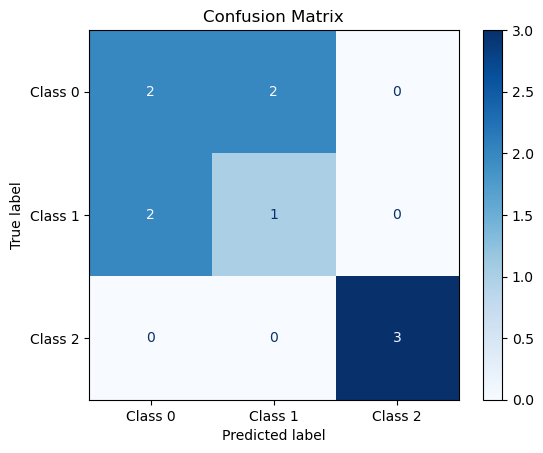

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have your true labels (y_true) and predicted labels (y_pred)
y_true = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0]
y_pred = [0, 0, 2, 1, 1, 2, 1, 0, 2, 0]

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Create the confusion matrix plot with a light sky blue color scheme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap="Blues")  # Set the color scheme to "lightblue"
plt.title("Confusion Matrix")
plt.show()

In [50]:
#CNN Model oversampling  ..........
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 3
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=5, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

In [52]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

> Average Accuracy across 3-folds: 90.46% (+/- 0.48%)


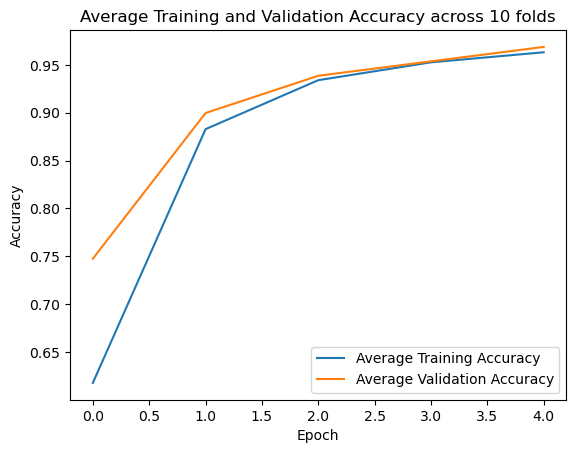

In [54]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1193/1193 [==============================] - 2s 2ms/step


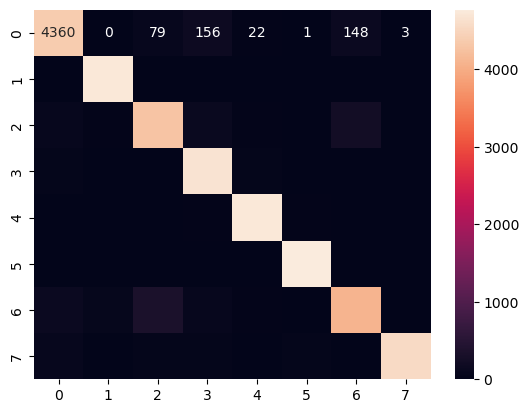

In [64]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [12]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.95      0.95      0.95      4769
     confusion       0.99      1.00      0.99      4769
disappointment       0.97      0.96      0.96      4769
      distrust       0.96      0.99      0.97      4769
       disgust       0.99      0.99      0.99      4769
   frustration       0.99      1.00      0.99      4769
          fear       0.94      0.94      0.94      4769
       sadness       1.00      0.97      0.98      4769

      accuracy                           0.97     38152
     macro avg       0.97      0.97      0.97     38152
  weighted avg       0.97      0.97      0.97     38152



New Code

398/398 [==============================] - 1s 2ms/step
> Average Accuracy across 3-folds: 90.35% (+/- 0.41%)


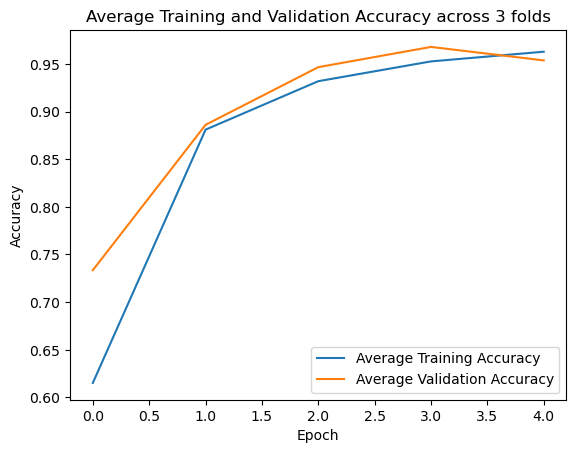

                precision    recall  f1-score   support

         anger       0.84      0.87      0.86      4769
     confusion       0.96      0.99      0.98      4769
disappointment       0.78      0.78      0.78      4769
      distrust       0.91      0.97      0.94      4769
       disgust       0.98      0.99      0.98      4769
   frustration       0.99      1.00      0.99      4769
          fear       0.76      0.67      0.71      4769
       sadness       0.99      0.95      0.97      4769

      accuracy                           0.90     38152
     macro avg       0.90      0.90      0.90     38152
  weighted avg       0.90      0.90      0.90     38152



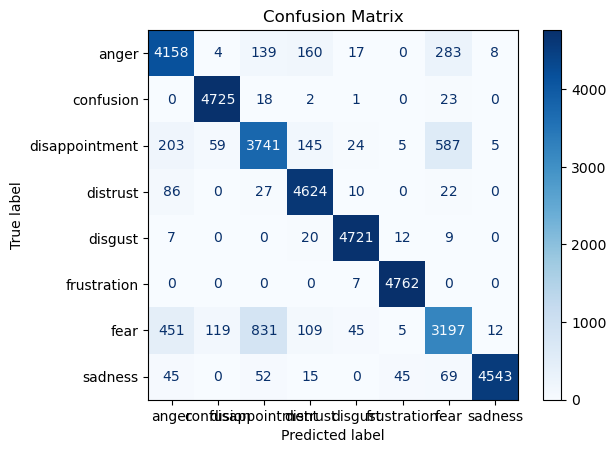

In [67]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 3
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []
y_true_classes = []
y_pred_classes = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=5, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    
    y_pred = model.predict(X_resampled[test])
    y_pred_classes_fold = np.argmax(y_pred, axis=1)
    y_true_classes_fold = np.argmax(y_resampled[test], axis=1)
    
    y_true_classes.extend(y_true_classes_fold)
    y_pred_classes.extend(y_pred_classes_fold)
    
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 3 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(y_dict.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

120/120 [==============================] - 0s 2ms/step
> Average Accuracy across 10-folds: 92.37% (+/- 0.66%)


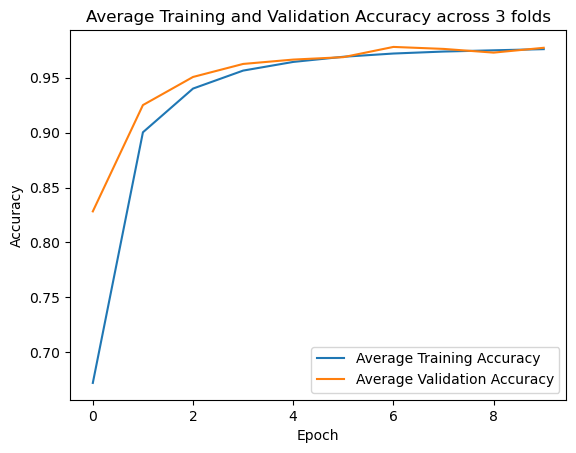

                precision    recall  f1-score   support

         anger       0.89      0.91      0.90      4769
     confusion       0.97      0.99      0.98      4769
disappointment       0.81      0.82      0.82      4769
      distrust       0.94      0.98      0.96      4769
       disgust       0.98      0.99      0.99      4769
   frustration       0.99      1.00      0.99      4769
          fear       0.81      0.72      0.76      4769
       sadness       0.99      0.98      0.99      4769

      accuracy                           0.92     38152
     macro avg       0.92      0.92      0.92     38152
  weighted avg       0.92      0.92      0.92     38152



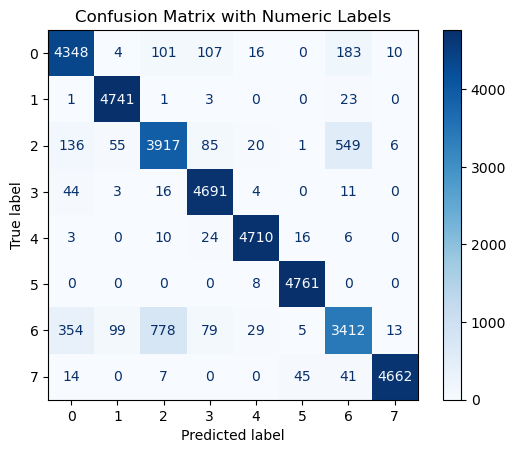

In [72]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []
y_true_classes = []
y_pred_classes = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    
    y_pred = model.predict(X_resampled[test])
    y_pred_classes_fold = np.argmax(y_pred, axis=1)
    y_true_classes_fold = np.argmax(y_resampled[test], axis=1)
    
    y_true_classes.extend(y_true_classes_fold)
    y_pred_classes.extend(y_pred_classes_fold)
    
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 3 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

# Confusion Matrix with Numeric Labels
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(len(y_dict)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Numeric Labels')
plt.show()

In [14]:







#CNN Model ChatGpt Dataset undersampling  ..........
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler  # Import RandomUnderSampler for undersampling

# 1. Load and Preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Undersample to balance classes
undersampler = RandomUnderSampler(random_state=42)  # Use RandomUnderSampler for undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)



# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1


In [16]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')


> Average Accuracy across 10-folds: 35.30% (+/- 4.95%)


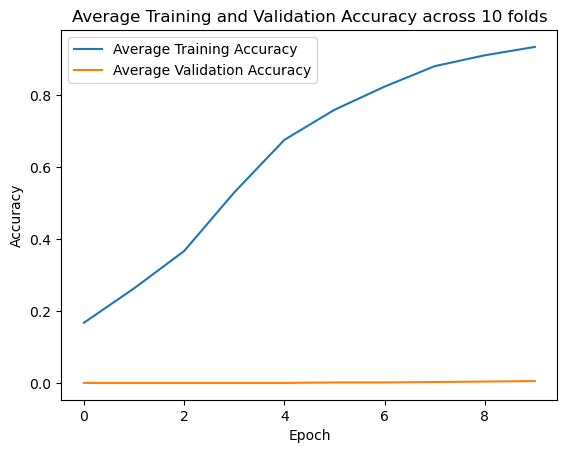

In [18]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


19/19 [==============================] - 0s 12ms/step


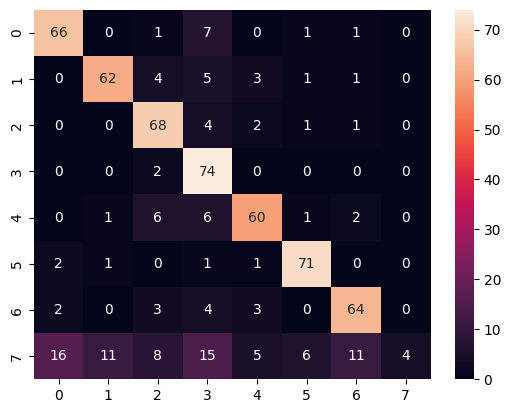

In [26]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [27]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.77      0.87      0.81        76
     confusion       0.83      0.82      0.82        76
disappointment       0.74      0.89      0.81        76
      distrust       0.64      0.97      0.77        76
       disgust       0.81      0.79      0.80        76
   frustration       0.88      0.93      0.90        76
          fear       0.80      0.84      0.82        76
       sadness       1.00      0.05      0.10        76

      accuracy                           0.77       608
     macro avg       0.81      0.77      0.73       608
  weighted avg       0.81      0.77      0.73       608



1195/1195 [==============================] - 7s 6ms/step


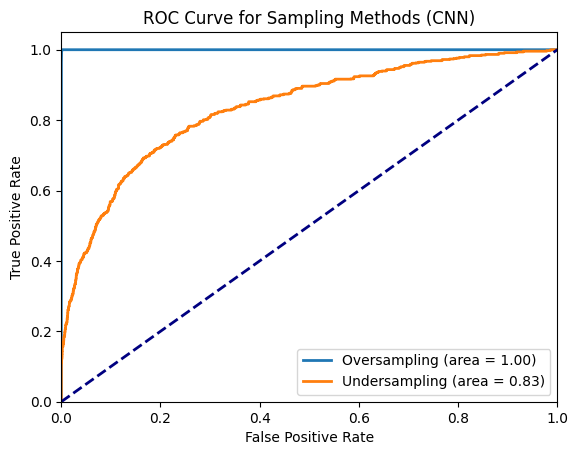

In [28]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Load and preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])

X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

# Define class labels, oversampling, and undersampling
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model for oversampling
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
model_oversampling = create_model()
model_oversampling.fit(X_oversampled, y_oversampled, epochs=10, batch_size=32, verbose=0)

# Train and evaluate the model for undersampling
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)
model_undersampling = create_model()
model_undersampling.fit(X_undersampled, y_undersampled, epochs=10, batch_size=32, verbose=0)

# Function to plot ROC curve and calculate AUC
def plot_roc_auc(models, X, y, titles):
    plt.figure()
    for model, title in zip(models, titles):
        y_pred = model.predict(X)
        fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{title} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Sampling Methods (CNN)')
    plt.legend(loc='lower right')
    plt.show()

# Plot both ROC curves on the same diagram
plot_roc_auc([model_oversampling, model_undersampling], X_oversampled, y_oversampled[:, 1], titles=['Oversampling', 'Undersampling'])


In [1]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

1195/1195 [==============================] - 3s 2ms/step


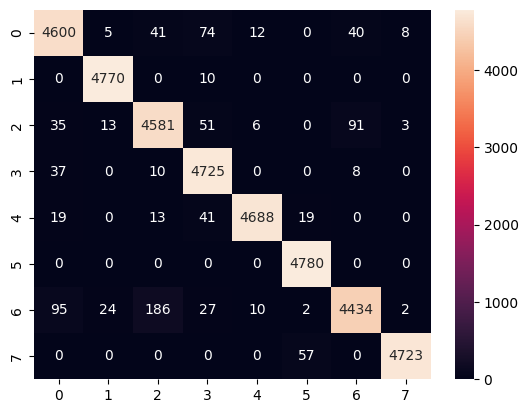

In [3]:
# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# ROC Curve
n_classes = len(y_dict)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_resampled[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



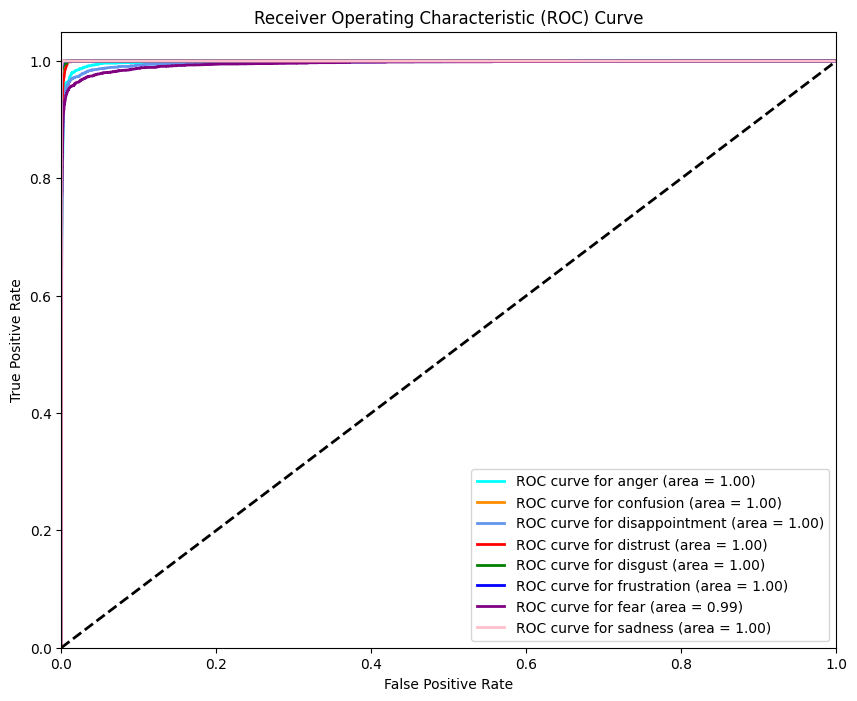

In [6]:
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'pink']
for i in range(n_classes):
   plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for {list(y_dict.keys())[i]} (area = {roc_auc[i]:.2f})')

    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()



In [7]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                precision    recall  f1-score   support

         anger       0.96      0.96      0.96      4780
     confusion       0.99      1.00      0.99      4780
disappointment       0.95      0.96      0.95      4780
      distrust       0.96      0.99      0.97      4780
       disgust       0.99      0.98      0.99      4780
   frustration       0.98      1.00      0.99      4780
          fear       0.97      0.93      0.95      4780
       sadness       1.00      0.99      0.99      4780

      accuracy                           0.98     38240
     macro avg       0.98      0.98      0.98     38240
  weighted avg       0.98      0.98      0.98     38240



In [18]:
# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')



> Average Accuracy across 10-folds: 93.97% (+/- 0.23%)


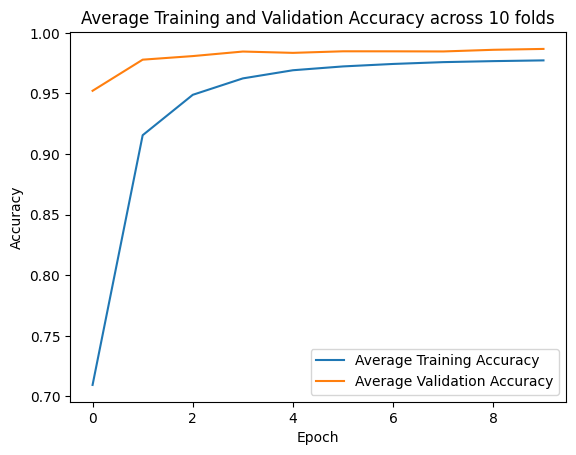

In [19]:
# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
